### Importing Libraries

In [ ]:
pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.7/251.7 kB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.4 MB/s eta 0:00:00


In [ ]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

import torch.optim as optim

import os

from PIL import Image, ImageOps, ImageEnhance

import random
import time

#import any other library you need below this line
from google.colab import drive
import wandb
import random
from scipy.ndimage import gaussian_filter, map_coordinates
from scipy.interpolate import griddata


### Loading data

Upload the data in zip format to Colab. Then run the cell below.

In [ ]:
drive.mount('/content/drive')
!unzip drive/MyDrive/data.zip

Mounted at /content/drive
Archive:  drive/MyDrive/data.zip
   creating: data/
  inflating: __MACOSX/._data         
   creating: data/cells/
  inflating: __MACOSX/data/._cells   
  inflating: data/.DS_Store          
  inflating: __MACOSX/data/._.DS_Store  
  inflating: data/cells/.DS_Store    
  inflating: __MACOSX/data/cells/._.DS_Store  
   creating: data/cells/scans/
  inflating: __MACOSX/data/cells/._scans  
   creating: data/cells/labels/
  inflating: __MACOSX/data/cells/._labels  
  inflating: data/cells/scans/BMMC_16.bmp  
  inflating: __MACOSX/data/cells/scans/._BMMC_16.bmp  
  inflating: data/cells/scans/BMMC_17.bmp  
  inflating: __MACOSX/data/cells/scans/._BMMC_17.bmp  
  inflating: data/cells/scans/BMMC_15.bmp  
  inflating: __MACOSX/data/cells/scans/._BMMC_15.bmp  
  inflating: data/cells/scans/BMMC_14.bmp  
  inflating: __MACOSX/data/cells/scans/._BMMC_14.bmp  
  inflating: data/cells/scans/BMMC_28.bmp  
  inflating: __MACOSX/data/cells/scans/._BMMC_28.bmp  
  inflating:

### Defining the Dataset Class

In [16]:
class Cell_data(Dataset):
  def __init__(self, data_dir, size, train = 'True', train_test_split = 0.8, augment_data = True):
    ##########################inputs##################################
    #data_dir(string) - directory of the data#########################
    #size(int) - size of the images you want to use###################
    #train(boolean) - train data or test data#########################
    #train_test_split(float) - the portion of the data for training###
    #augment_data(boolean) - use data augmentation or not#############
    super(Cell_data, self).__init__()

    # Initialisation
    self.data_dir = data_dir
    self.size = size
    self.augment_data = augment_data

    # List all image files in the directory
    all_files = [f for f in os.listdir(data_dir + '/scans') if os.path.isfile(os.path.join(data_dir + '/scans', f))]
    #Splitting dataset based on the train_test_split ratio
    split_idx = int(len(all_files) * train_test_split)
    if train:
        self.images = all_files[:split_idx]
    else:
        self.images = all_files[split_idx:]


  def __getitem__(self, idx):
    # load image and mask from index idx of your data
    img_path = os.path.join(self.data_dir, 'scans', self.images[idx])
    mask_path = os.path.join(self.data_dir, 'labels',
                              self.images[idx])  # Assuming masks have same filenames as images

    image = Image.open(img_path).convert("L")  # Convert to grayscale
    mask = Image.open(mask_path).convert("L")

    image = image.resize((self.size, self.size))
    mask = mask.resize((self.size, self.size))

    #data augmentation part
    if self.augment_data:
        augment_mode = np.random.randint(0, 4)
        #augment_mode = 3; # for testing the performance of each augmentation method
        if augment_mode == 0:
        # Randomly choose between vertical and horizontal flip
          if random.random() > 0.5:
              # flip image vertically
              image = ImageOps.flip(image)
              mask = ImageOps.flip(mask)
          else:
              # flip image horizontally (mirror)
              image = ImageOps.mirror(image)
              mask = ImageOps.mirror(mask)
        elif augment_mode == 1:
          # zoom image
          zoom_factor = np.random.uniform(1.1, 1.5)
          new_size = (int(image.size[0] * zoom_factor), int(image.size[1] * zoom_factor))
          image_new = image.resize(new_size, Image.LANCZOS)
          mask_new = mask.resize(new_size, Image.LANCZOS)
          # Crop to the model input size:
          x1 = (new_size[1] - image.size[0]) // 2
          y1 = (new_size[1] - image.size[1]) // 2
          x2 = x1 + image.size[0]
          y2 = y1 + image.size[1]
          image = image_new.crop((x1, y1, x2, y2))
          mask = mask_new.crop((x1, y1, x2, y2))
        elif augment_mode == 2:
          # rotate image
          angle = np.random.uniform(-45, 45)
          image = ImageOps.exif_transpose(image.rotate(angle))
          mask = ImageOps.exif_transpose(mask.rotate(angle))

        elif augment_mode == 3:
          # Apply smooth deformation
          image = self.smooth_deformation(image)
          mask = self.smooth_deformation(mask)


      # return image and mask in tensors
    image = torch.FloatTensor(np.array(image)).unsqueeze(0) / 255.0
    mask = torch.FloatTensor(np.array(mask)).unsqueeze(0)
    return image, mask




  def __len__(self):
    return len(self.images)

  # the function of data augmentation method.
  def smooth_deformation(self, image, std_dev=10, alpha=3):
      # Convert PIL image to numpy array
      img_array = np.array(image)

      # Generate random displacement fields
      dx = np.random.uniform(-1, 1, img_array.shape[:2])
      dy = np.random.uniform(-1, 1, img_array.shape[:2])

      # Smooth the displacement fields with a Gaussian filter
      dx = gaussian_filter(dx, sigma=std_dev, mode='reflect') * alpha
      dy = gaussian_filter(dy, sigma=std_dev, mode='reflect') * alpha

      # Create coordinate grid
      x, y = np.meshgrid(np.arange(img_array.shape[1]), np.arange(img_array.shape[0]))

      # Apply displacement fields
      indices = np.reshape(y + dy, (-1, 1)), np.reshape(x + dx, (-1, 1))

      # Remap the image
      deformed_array = map_coordinates(img_array, indices, order=1, mode='reflect').reshape(img_array.shape)

      # Convert numpy array back to PIL image
      return Image.fromarray(deformed_array.astype(np.uint8))

### Define the Model
1. Define the Convolution blocks
2. Define the down path
3. Define the up path
4. combine the down and up path to get the final model

In [ ]:
base_filters = 64
class twoConvBlock(nn.Module):
  def __init__(self, input_channel, output_channel):
    super(twoConvBlock, self).__init__()
    #Define a 3 × 3 un-padded convolution layer
    self.conv1 = nn.Conv2d(input_channel, output_channel, kernel_size=3, padding=0)

    # Define another 3 × 3 un-padded convolution layer which keeps the number of channels unchanged
    self.conv2 = nn.Conv2d(output_channel, output_channel, kernel_size=3, padding=0)

    # Define a batch normalization layer
    self.batch_norm = nn.BatchNorm2d(output_channel)

  def forward(self, x):
    # Apply the first convolution layer and then ReLU
    x = F.relu(self.conv1(x))

    # Apply the second convolution layer
    x = self.conv2(x)

    # Apply the batch normalization layer
    x = self.batch_norm(x)

    # Apply ReLu a second time
    x = F.relu(x)

    return x

class downStep(nn.Module):
  def __init__(self, input_channel):
    super(downStep, self).__init__()

    # In each block the number of channels doubles (Except for the first block which takes 1 channel and outputs 64 channels)
    self.output_channel = 2 * input_channel if input_channel != 1 else base_filters

    # Define the Convolutional blocks
    self.twoConvBlock = twoConvBlock(input_channel, self.output_channel)

    # Define a 2 × 2 max-pooling layer
    self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

  def forward(self, x):
    # Apply the two Convolution layers block
    before_pool = self.twoConvBlock(x)

    # Apply the max pooling layer
    after_pool = self.maxpool(before_pool)

    return after_pool, before_pool

class upStep(nn.Module):
  def __init__(self, input_channel):
    super(upStep, self).__init__()
    # Define an unsampling layer, half the output channel
    self.output_channel = input_channel // 2
    self.upsampling = nn.ConvTranspose2d(input_channel, self.output_channel, kernel_size=2, stride=2)

    # Define the Convolutional block
    self.twoConvBlock = twoConvBlock(2 * self.output_channel, self.output_channel)



  def forward(self, x, skip_connection):
    # Apply the unsampling layer
    x = self.upsampling(x)
    # Apply the convolution, the input of which comes from concatenating this feature map with a skip connection feature map
    crop_y = (skip_connection.size()[2] - x.size()[2]) // 2
    crop_x = (skip_connection.size()[3] - x.size()[3]) // 2
    # Check if after cropping by 'crop_y' and 'crop_x', the dimensions of 'skip_connection' match with 'x'
    # If not, crop an additional row/column
    additional_y = 0 if (skip_connection.size()[2] - 2 * crop_y) == x.size()[2] else 1
    additional_x = 0 if (skip_connection.size()[3] - 2 * crop_x) == x.size()[3] else 1

    skip_connection = skip_connection[:, :, crop_y : skip_connection.size()[2] - crop_y - additional_y,
                                 crop_x : skip_connection.size()[3] - crop_x - additional_x]
    # Concatenate on the channels dimension
    x = torch.cat([skip_connection, x], dim=1)
    x = self.twoConvBlock(x)

    return x

class UNet(nn.Module):
  def __init__(self, in_channels=1, out_channels=2, depth=4):
    super(UNet, self).__init__()

    self.encoders = nn.ModuleList()
    self.decoders = nn.ModuleList()
    # Contracting Path
    in_ch = in_channels
    for _ in range(depth):
      self.encoders.append(downStep(in_ch))
      in_ch = self.encoders[-1].output_channel

    # Bottleneck Path
    self.bottleneck = twoConvBlock(in_ch, in_ch * 2)
    in_ch *= 2

    # Expansive Path
    for _ in range(depth):
      self.decoders.append(upStep(in_ch))
      in_ch = self.decoders[-1].output_channel

    # Final layer to produce the segmentation map
    self.final = nn.Conv2d(base_filters, out_channels, kernel_size=1, padding=0)


  def forward(self, x):
    # Apply contracting path
    skip_connections = []
    for encoder in self.encoders:
      x, before_pool = encoder(x)
      skip_connections.append(before_pool)

    # Apply bottleneck path
    x = self.bottleneck(x)


    # Apply expansive path
    for decoder, skip_connection in zip(self.decoders, reversed(skip_connections)):
      x = decoder(x, skip_connection)

    # Apply final layer
    x = self.final(x)
    return x





### Training

In [12]:
torch.cuda.empty_cache()

#Paramteres

#learning rate
lr = 1e-2

#number of training epochs
epoch_n = 10

#input image-mask size
image_size = 572
#root directory of project
root_dir = os.getcwd()

#training batch size
batch_size = 8

#use checkpoint model for training
load = False

#use GPU for training
gpu = True

data_dir = os.path.join(root_dir, 'data/cells')

# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="VClab-Unet",

    # track hyperparameters and run metadata
    config={
    "learning_rate": lr,
    "architecture": "Unet",
    "dataset": "Cells",
    "epochs": epoch_n,
    "size of image": image_size,
    "batch size": batch_size
    }
)

trainset = Cell_data(data_dir = data_dir, size = image_size)
trainloader = DataLoader(trainset, batch_size = batch_size, shuffle=True)
testset = Cell_data(data_dir = data_dir, size = image_size, train = False)
testloader = DataLoader(testset, batch_size = batch_size)

device = torch.device('cuda:0' if gpu else 'cpu')

model = UNet().to('cuda:0').to(device)

if load:
  print('loading model')
  model.load_state_dict(torch.load('checkpoint.pt'))

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.0005)

train_losses = []
test_losses = []
start_time = time.time()

model.train()
for e in range(epoch_n):
  epoch_loss = 0
  model.train()
  for i, data in enumerate(trainloader):
    image, label = data
    image = image.to(device)
    label = label.long().to(device)

    pred = model(image)
    crop_x = (label.shape[2] - pred.shape[2]) // 2
    crop_y = (label.shape[2] - pred.shape[3]) // 2

    label = label[:, :, crop_x: label.shape[2] - crop_x, crop_y: label.shape[3] - crop_y]

    label = label.squeeze(1)
    loss = criterion(pred, label)

    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

    epoch_loss += loss.item()

    #print('batch %d --- Loss: %.4f' % (i, loss.item() / batch_size))

  train_losses.append(epoch_loss / trainset.__len__())
  print('Epoch %d / %d --- Loss: %.4f' % (e + 1, epoch_n, epoch_loss / trainset.__len__()))
  wandb.log({"training loss": epoch_loss / trainset.__len__()})


  torch.save(model.state_dict(), 'checkpoint.pt')

  model.eval()

  total = 0
  correct = 0
  total_loss = 0

  with torch.no_grad():
    for i, data in enumerate(testloader):
      image, label = data

      image = image.to(device)
      label = label.long().to(device)

      pred = model(image)
      crop_x = (label.shape[2] - pred.shape[2]) // 2
      crop_y = (label.shape[2] - pred.shape[3]) // 2

      label = label[:, :, crop_x: label.shape[2] - crop_x, crop_y: label.shape[3] - crop_y]

      label = label.squeeze(1)
      loss = criterion(pred, label)
      total_loss += loss.item()

      _, pred_labels = torch.max(pred, dim = 1)

      total += label.shape[0] * label.shape[1] * label.shape[2]
      correct += (pred_labels == label).sum().item()

    test_losses.append(total_loss / testset.__len__())
    print('Accuracy: %.4f ---- Loss: %.4f' % (correct / total, total_loss / testset.__len__()))
    wandb.log({"Accuracy": correct / total, "validation loss": total_loss / testset.__len__()})

end_time = time.time()

# Calculate and print the total training time
total_time = end_time - start_time
wandb.log({'time used': total_time})
print(f"Total training time: {total_time:.2f} seconds")
wandb.finish()





Epoch 1 / 10 --- Loss: 0.1099
Accuracy: 0.5105 ---- Loss: 209836.9531
Epoch 2 / 10 --- Loss: 0.0798
Accuracy: 0.5785 ---- Loss: 42.0655
Epoch 3 / 10 --- Loss: 0.0749
Accuracy: 0.6111 ---- Loss: 0.2665
Epoch 4 / 10 --- Loss: 0.0845
Accuracy: 0.7808 ---- Loss: 0.0591
Epoch 5 / 10 --- Loss: 0.0793
Accuracy: 0.8089 ---- Loss: 0.0615
Epoch 6 / 10 --- Loss: 0.0736
Accuracy: 0.8673 ---- Loss: 0.0427
Epoch 7 / 10 --- Loss: 0.0710
Accuracy: 0.8558 ---- Loss: 0.0561
Epoch 8 / 10 --- Loss: 0.0726
Accuracy: 0.8534 ---- Loss: 0.0558
Epoch 9 / 10 --- Loss: 0.0700
Accuracy: 0.8688 ---- Loss: 0.0519
Epoch 10 / 10 --- Loss: 0.0733
Accuracy: 0.8765 ---- Loss: 0.0579
Total training time: 101.36 seconds


Accuracy,▁▂▃▆▇█████
time used,▁
training loss,█▃▂▄▃▂▁▁▁▂
validation loss,█▁▁▁▁▁▁▁▁▁
Accuracy,0.87648
time used,101.35963
training loss,0.07326
validation loss,0.05794


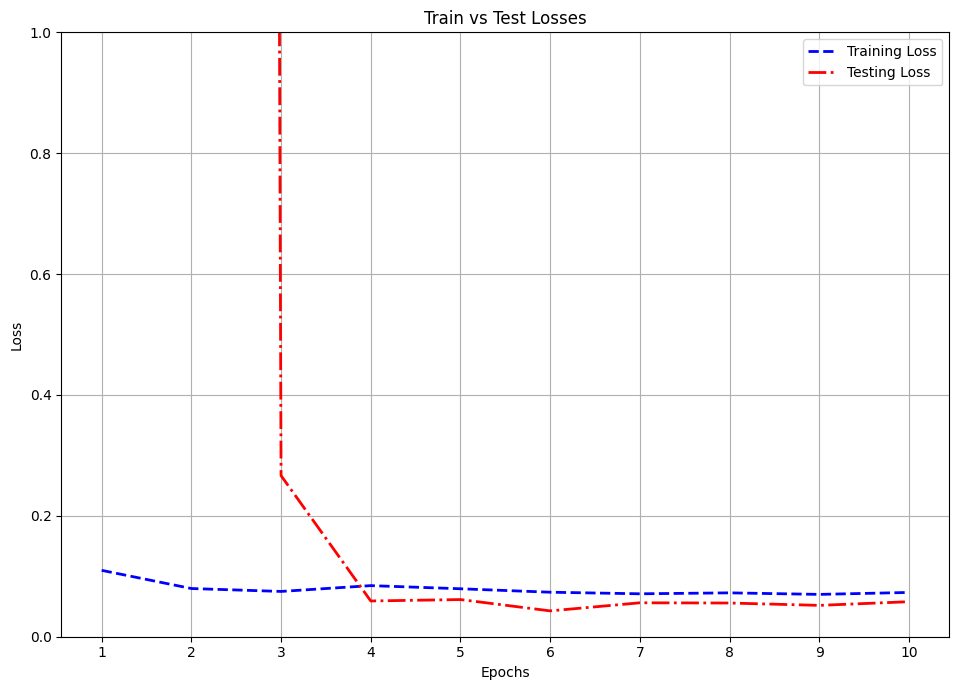

In [13]:
# Plotting the training and testing losses
plt.figure(figsize=(10, 7))

plt.plot(train_losses, label='Training Loss', color='blue', linestyle='--', linewidth=2)
plt.plot(test_losses, label='Testing Loss', color='red', linestyle='-.', linewidth=2)

plt.xlabel('Epochs')
plt.ylabel('Loss')

num_epochs = len(train_losses)
plt.xticks(range(num_epochs), [str(i+1) for i in range(num_epochs)])

plt.title('Train vs Test Losses')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.ylim(0.0, 1)

plt.show()

### Testing and Visualization

In [14]:
model.eval()


output_masks = []
output_labels = []

with torch.no_grad():
  for i in range(testset.__len__()):
    image, labels = testset.__getitem__(i)
    input_image = image.unsqueeze(0).to(device)
    pred = model(input_image)


    output_mask = torch.max(pred, dim = 1)[1].cpu().squeeze(0).numpy()

    labels = labels.squeeze(0)
    crop_x = (labels.shape[0] - output_mask.shape[0]) // 2
    crop_y = (labels.shape[1] - output_mask.shape[1]) // 2
    labels = labels[crop_x: labels.shape[0] - crop_x, crop_y: labels.shape[1] - crop_y].numpy()
    output_masks.append(output_mask)
    output_labels.append(labels)


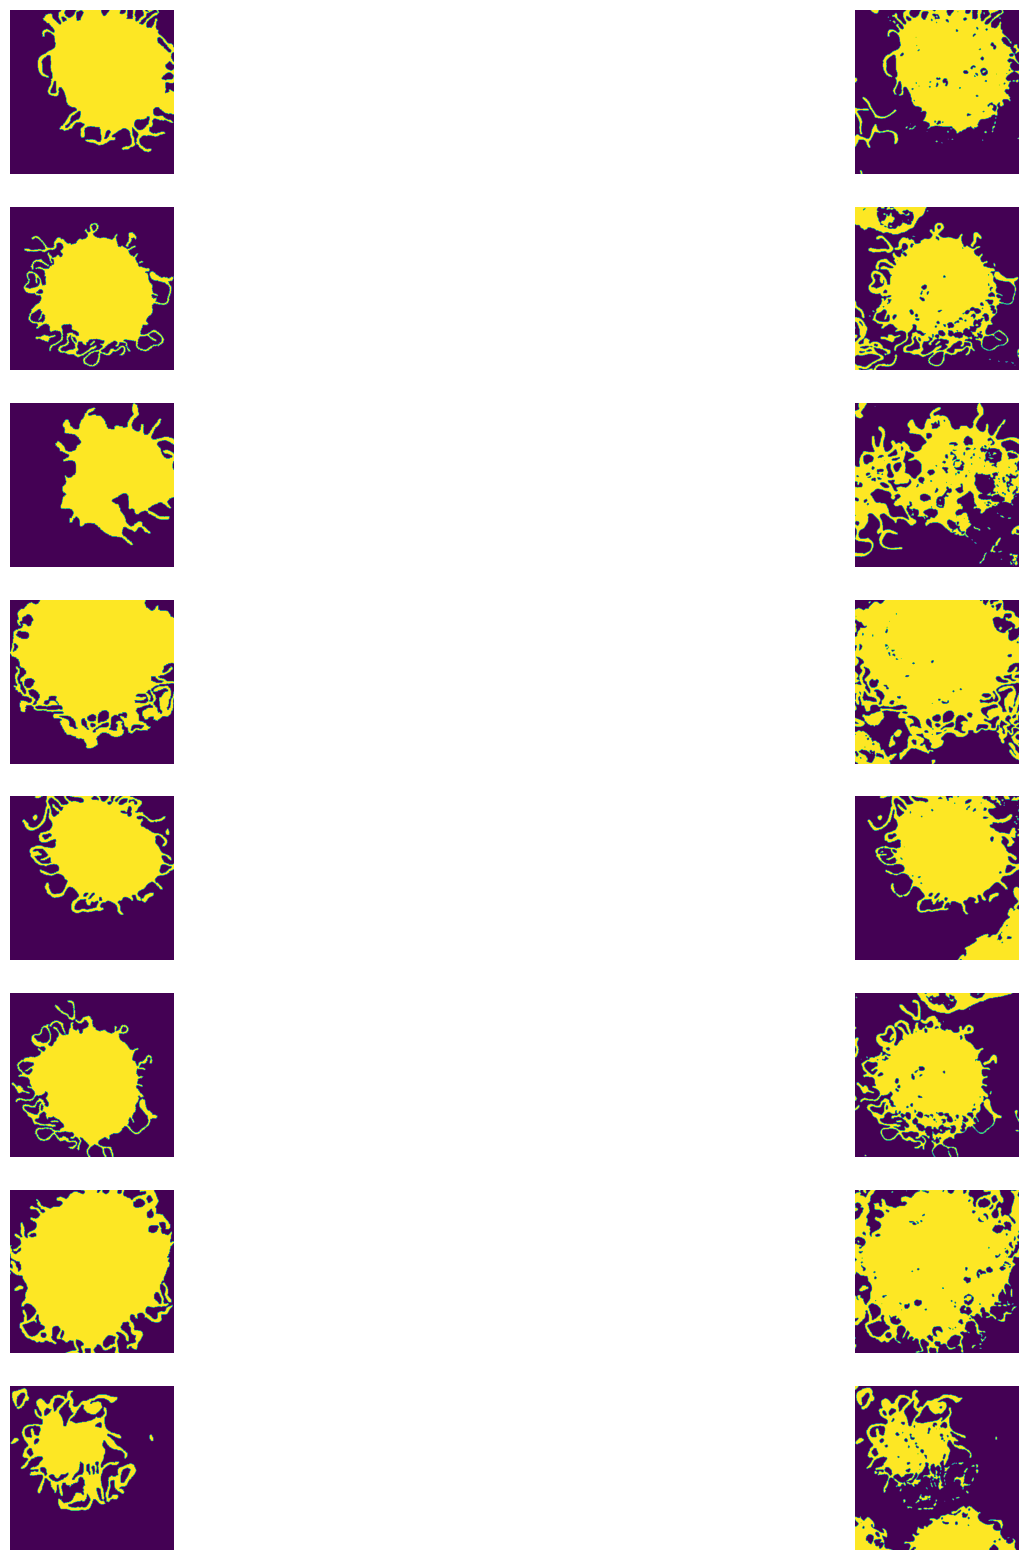

In [15]:
fig, axes = plt.subplots(testset.__len__(), 2, figsize = (20, 20))

for i in range(testset.__len__()):
  axes[i, 0].imshow(output_labels[i])
  axes[i, 0].axis('off')
  axes[i, 1].imshow(output_masks[i])
  axes[i, 1].axis('off')